In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.append("../core")
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from scipy.interpolate import RegularGridInterpolator, splrep, splev
from settings import *
from tools import get_mids

In [3]:
print(LIVETIME)
print(GAMMA_ASTRO)
print(PHI_ASTRO)

315567360.0
2.28
1.44e-18


# Ple$\nu$m calculation

### local coordinates

In [2]:
coords = {
    'IceCube': {"lon": 0*u.deg, "lat": -90*u.deg},
    'P-ONE': {"lon": -123.3656*u.deg, "lat": 48.4284*u.deg},
    'KM3NeT': {"lon": (16 + 6/60)*u.deg, "lat": (36 + 16/60)*u.deg},
    'Baikal-GVD': {"lon": 108.1650*u.deg, "lat": 53.5587*u.deg}
}

# Get aeff

In [4]:
# MCEQ atmospheric background
with open("../resources/MCEq_flux.pckl", "rb") as f:
    (e_grid, zen), flux_def = pickle.load(f)
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), 
    np.log(flux_def['numu_conv'])
)

In [4]:
# show the public detection efficiency 
d_public = np.genfromtxt(
    '../icecube_10year_ps/irfs/IC86_II_effectiveArea.csv',
    skip_header=1
)
# log10(E_nu/GeV)_min log10(E_nu/GeV)_max
# Dec_nu_min[deg] Dec_nu_max[deg]
# A_Eff[cm^2]
emin, emax = np.power(10, [d_public[:,0], d_public[:,1]])
sindec_min, sindec_max = np.sin(np.deg2rad([d_public[:,2], d_public[:,3]]))
# actually it's cos(zen), but we'll just switch the eff area ordering
aeff = d_public[:,4]

emin = np.unique(emin) # all lower energy bounds
emax = np.unique(emax) # all upper energy bounds
ebins = np.unique([emin, emax]) # all bin edges in order
sindec_min = np.unique(sindec_min) # all lower sindec bounds
sindec_max = np.unique(sindec_max) # all upper sindec bounds
sindec_bins = np.unique([sindec_min, sindec_max]) # all bin edges in order
ra_bins = np.linspace(0, np.pi*2, num=101)
ra_mids = get_mids(ra_bins)
ra_width = ra_bins[1:] - ra_bins[:-1]

aeff_2d = dict()
# re-shape into 2D array with (A(E) x A(delta))
# and switch the eff area ordering
aeff_2d["icecube_full"] = aeff.reshape(len(sindec_min), len(emin)).T

emids = get_mids(ebins)
ewidth = emax - emin
sindec_mids = get_mids(sindec_bins)
sindec_width = sindec_max - sindec_min

print(len(emin), "log_10(energy) bins")
print(len(sindec_min), "declination bins")

# cut at delta > -5deg
min_idx = np.searchsorted(sindec_mids, np.sin(np.deg2rad(-5)))
print(f"Below {np.rad2deg(np.arcsin(sindec_min[min_idx])):1.2f}deg aeff is 0")
aeff_2d["icecube"] = np.copy(aeff_2d["icecube_full"])
aeff_2d["icecube"][:,:min_idx] = 0

# grid for MCEq flux evaluation
ee, ss = np.meshgrid(emids, sindec_mids)
spl_vals = np.exp(rgi((ee, ss)))

# some event numbers for checking
det = "icecube"
aeff_factor = (aeff_2d[det] * sindec_width).T * ewidth * LIVETIME * np.sum(ra_width)
astro_ev = aeff_factor * (emids/1E5)**(-GAMMA_ASTRO) * PHI_ASTRO
atm_ev = aeff_factor * spl_vals
print(det)
print("conv events:", np.sum(atm_ev))
print("astro events:", np.sum(astro_ev))

NameError: name 'calc_mids' is not defined

## Idea: transform the integration over R.A. per sin(dec) into local coordinates

**Note:** here, equal contributions of each detector are assumed. In case one wants to use different livetimes, the effective areas have to multiplied individually before calculating e.g. the expected number of astrophysical events

In [8]:
#%%timeit

# Interpolated grid of the effective area in "local" coordinates
# (= icecube's native coordinates)
grid2d = [RegularGridInterpolator(
    (np.arcsin(sindec_mids), ra_mids), # transform dec to local theta
    # switch back to local zenith, add ra as new axis and normalize accordingly
    aeff_2d["icecube"][i][::-1,np.newaxis] / np.atleast_2d(ra_width)/ len(ra_mids),
    method='linear',
    bounds_error=False,
    fill_value=0.
) for i in range(len(emids))]
# grid elements are calculated for each energy bin, grid is theta x phi

# coordinate grid in equatorial coordinates (icrs)
# these will be the integration coordinates
pp, tt = np.meshgrid(ra_mids, np.arcsin(sindec_mids))
eq_coords = SkyCoord(
    pp * u.radian,
    tt * u.radian,
    frame="icrs"
)

aeff_i = {}
factor = 10 # for plotting energy slices
aeff_i["Plenum-1"] = np.zeros_like(aeff_2d["icecube"])

# loop over detectors
for k, coord in coords.items():
    print(k)
    # local detector
    loc = EarthLocation(
        lat=coord["lat"],
        lon=coord["lon"],
    )
    # arbitrary time, doesnt matter here
    time = Time('2021-6-21 00:00:00')
    # transform integration coordinates to local frame
    local_coords = eq_coords.transform_to(AltAz(obstime=time, location=loc))
    # sum up the contributions over the transformed RA axis per declination 
    
    # loop over the energy bins to get the same shape of aeff as before
    # sum along transformed ra coordinates
    aeff_i[k] = np.array([np.sum(
        grid2d[i]((local_coords.alt.rad, local_coords.az.rad)) * ra_width, # integrate over RA
        axis=1) for i in range(len(emids))])
    aeff_i["Plenum-1"] += aeff_i[k]

IceCube
P-ONE
KM3NeT
Baikal-GVD


In [7]:
# GEN-2 will have ~7.5x effective area ==> 5times better discovery potential
aeff_i["Gen-2"] = aeff_i["IceCube"] * 5 ** (1 / 0.8)
aeff_i["Plenum-2"] = aeff_i["Plenum-1"] - aeff_i["IceCube"] + aeff_i["Gen-2"]

# same but wit FULL icecube effective area

In [9]:
#%%timeit

# Interpolated grid of the effective area in "local" coordinates
# (= icecube's native coordinates)
grid2d = [RegularGridInterpolator(
    (np.arcsin(sindec_mids), ra_mids), # transform dec to local theta
    # switch back to local zenith, add ra as new axis and normalize accordingly
    aeff_2d["icecube_full"][i][::-1,np.newaxis] / np.atleast_2d(ra_width)/ len(ra_mids),
    method='linear',
    bounds_error=False,
    fill_value=0.
) for i in range(len(emids))]
# grid elements are calculated for each energy bin, grid is theta x phi

# coordinate grid in equatorial coordinates (icrs)
# these will be the integration coordinates
pp, tt = np.meshgrid(ra_mids, np.arcsin(sindec_mids))
eq_coords = SkyCoord(
    pp * u.radian,
    tt * u.radian,
    frame="icrs"
)

aeff_i_full = {}
factor = 10 # for plotting energy slices
aeff_i_full["Plenum-1"] = np.zeros_like(aeff_2d["icecube_full"])

# loop over detectors
for k, coord in coords.items():
    print(k)
    # local detector
    loc = EarthLocation(
        lat=coord["lat"],
        lon=coord["lon"],
    )
    # arbitrary time, doesnt matter here
    time = Time('2021-6-21 00:00:00')
    # transform integration coordinates to local frame
    local_coords = eq_coords.transform_to(AltAz(obstime=time, location=loc))
    # sum up the contributions over the transformed RA axis per declination 
    
    # loop over the energy bins to get the same shape of aeff as before
    # sum along transformed ra coordinates
    aeff_i_full[k] = np.array([np.sum(
        grid2d[i]((local_coords.alt.rad, local_coords.az.rad)) * ra_width, # integrate over RA
        axis=1) for i in range(len(emids))])
    aeff_i_full["Plenum-1"] += aeff_i_full[k]

IceCube
P-ONE
KM3NeT
Baikal-GVD


In [10]:
# GEN-2 will have ~7.5x effective area ==> 5times better discovery potential
aeff_i_full["Gen-2"] = aeff_i_full["IceCube"] * 5 ** (1 / 0.8)
aeff_i_full["Plenum-2"] = aeff_i_full["Plenum-1"] - aeff_i_full["IceCube"] + aeff_i_full["Gen-2"]

## effective area checking plots

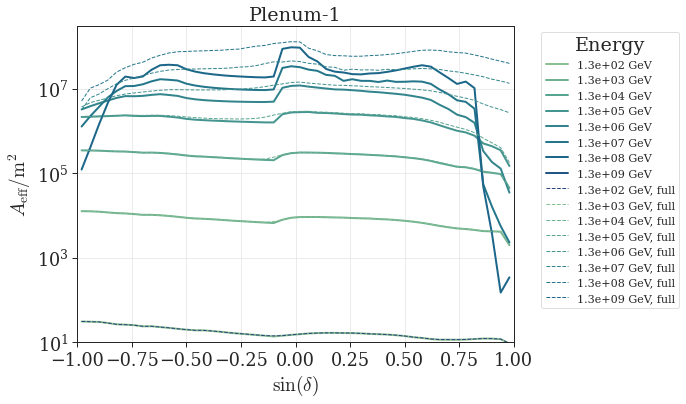

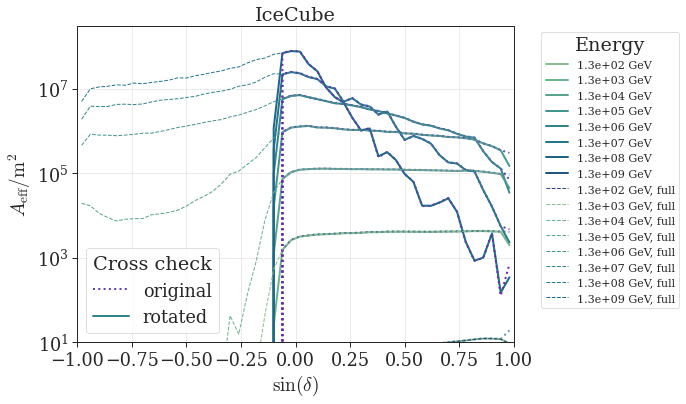

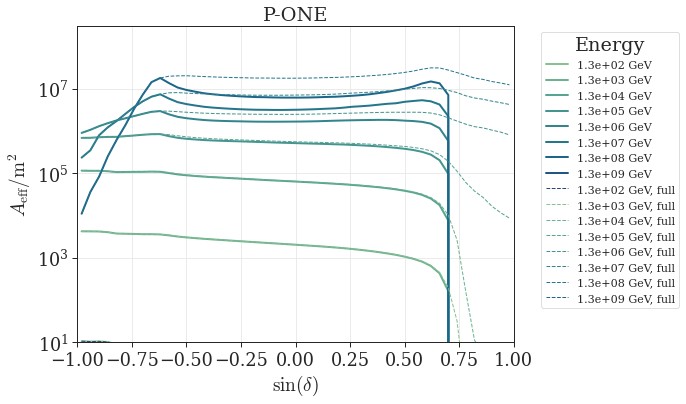

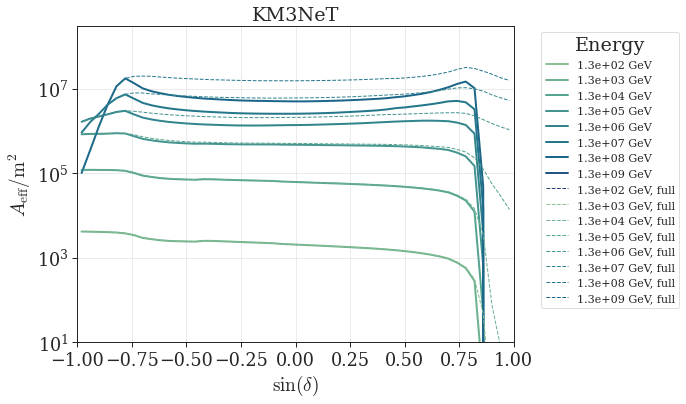

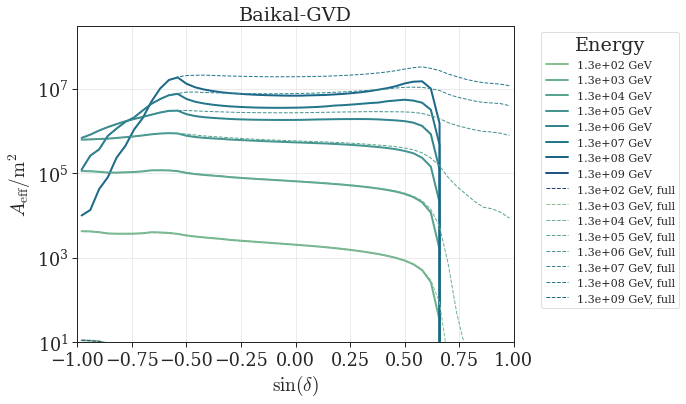

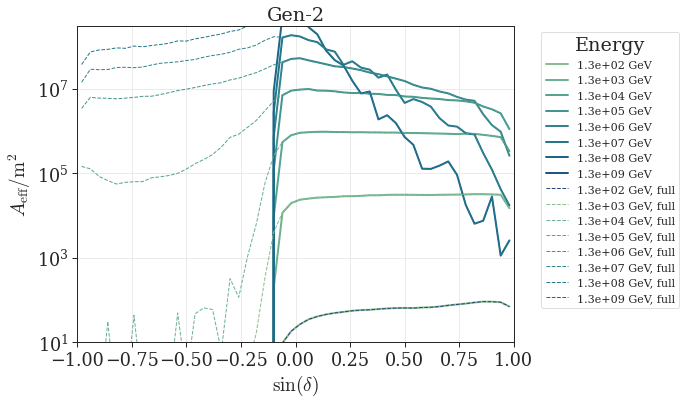

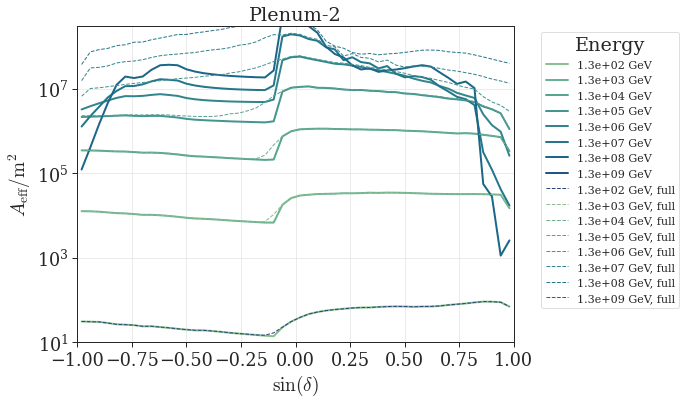

In [12]:
factor = 5
nlines = len(emids) // factor + 1
reset_palette(nlines)
mid_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][nlines // 2]
for k in aeff_i:
    plt.figure(figsize=(10, 6))
    for ie, ae in enumerate(aeff_i[k][::factor]):
        line = plt.plot(
            sindec_mids,
            ae,
            label=f"{emids[ie*factor]:1.1e} GeV",
            ls="-", # rotated
            lw=2
        )
        if k=="IceCube":
            plt.plot(
                sindec_mids, aeff_2d["icecube"][ie*factor],
                ls=":", # original
                color=slightly_change_color(line[0].get_color(), amount=0.2),
                lw=2
            )
    for ie, ae in enumerate(aeff_i_full[k][::factor]):
        line = plt.plot(
            sindec_mids,
            ae,
            label=f"{emids[ie*factor]:1.1e} GeV, full",
            ls="--", # rotated
            lw=1
        )
    plt.yscale("log")
    plt.title(k)
    if k=="IceCube":
        lines = [
            matplotlib.lines.Line2D(
                [0],
                [0],
                color=slightly_change_color(mid_color),
                linestyle=":"
            ),
            matplotlib.lines.Line2D(
                [0],
                [0],
                color=mid_color,
                linestyle="-")
        ]
        labels = ['original', 'rotated']
        lg = plt.legend(lines, labels, title="Cross check")

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Energy", fontsize="xx-small")
    if k=="IceCube":
        ax = plt.gca()
        ax.add_artist(lg)                
    plt.grid(True)
    plt.xlim(-1, 1)
    plt.ylim(10, 3E8)
    plt.xlabel(r"$\sin(\delta)$")
    plt.ylabel(r"$A_{\rm eff}/ {\rm m}^2$")
    plt.tight_layout()
    plt.savefig(f"../plots/{k}_alt_aeff.pdf")


## 2D plots

In [18]:
from matplotlib.colors import ListedColormap

In [25]:
cmap = ListedColormap(sns.color_palette("mako", n_colors=16))

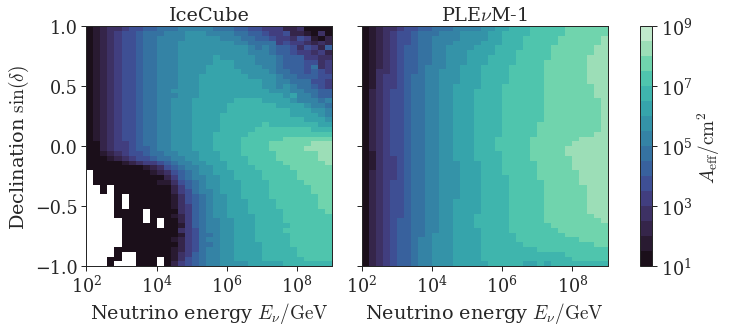

In [26]:
fig, axes=plt.subplots(ncols=2, figsize=(11,5), sharey=True)

ax = axes[0]
ax.set_title('IceCube')
p = ax.pcolormesh(
    ebins,
    sindec_bins, 
    aeff_i_full['IceCube'].T,
    norm=LogNorm(),
    vmin=10,
    vmax=1E9,
    cmap=cmap
)
ax.set_xscale("log")
ax.set_xlim(1E2, 1E9)
ax.set_ylabel(r'Declination $\sin(\delta)$')


ax = axes[1]
ax.set_title(r'PLE$\nu$M-1')
p = ax.pcolormesh(
    ebins,
    sindec_bins, 
    aeff_i_full['Plenum-1'].T,
    norm=LogNorm(),
    vmin=10,
    vmax=1E9,
    cmap=cmap
)
ax.set_xscale("log")
for ax in axes:
    ax.set_xlabel(r'Neutrino energy $E_\nu/{\rm GeV}$')
fig.tight_layout()
cb = fig.colorbar(p, ax=axes)
cb.set_label(r'$A_{\rm eff} / \rm cm^2$')
ax.set_xlim(1E2, 1E9)
fig.savefig("../plots/aeff_comparison_IC_PLENUM-1.pdf")

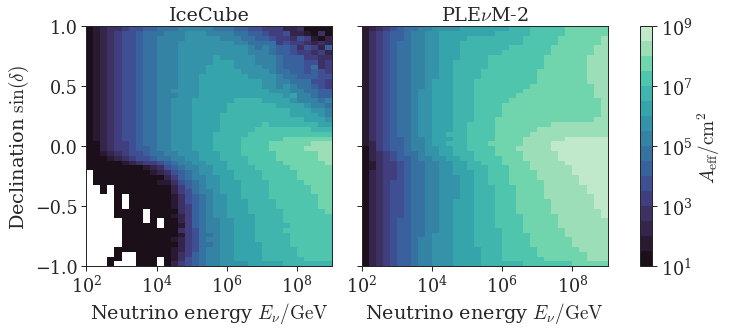

In [27]:
fig, axes=plt.subplots(ncols=2, figsize=(11,5), sharey=True)

ax = axes[0]
ax.set_title('IceCube')
p = ax.pcolormesh(
    ebins,
    sindec_bins, 
    aeff_i_full['IceCube'].T,
    norm=LogNorm(),
    vmin=10,
    vmax=1E9,
    cmap=cmap
)
ax.set_xscale("log")
#cb = fig.colorbar(p,ax=ax)
#cb.set_label(r'$A_{\rm eff} / \rm cm^2$')
ax.set_xlim(1E2, 1E9)
ax.set_ylabel(r'Declination $\sin(\delta)$')


ax = axes[1]
ax.set_title(r'PLE$\nu$M-2')
p = ax.pcolormesh(
    ebins,
    sindec_bins, 
    aeff_i_full['Plenum-2'].T,
    norm=LogNorm(),
    vmin=10,
    vmax=1E9,
    cmap=cmap
)
ax.set_xscale("log")
for ax in axes:
    ax.set_xlabel(r'Neutrino energy $E_\nu/{\rm GeV}$')
fig.tight_layout()
cb = fig.colorbar(p, ax=axes)
cb.set_label(r'$A_{\rm eff} / \rm cm^2$')
ax.set_xlim(1E2, 1E9)
fig.savefig("../plots/aeff_comparison_IC_PLENUM-2.pdf")

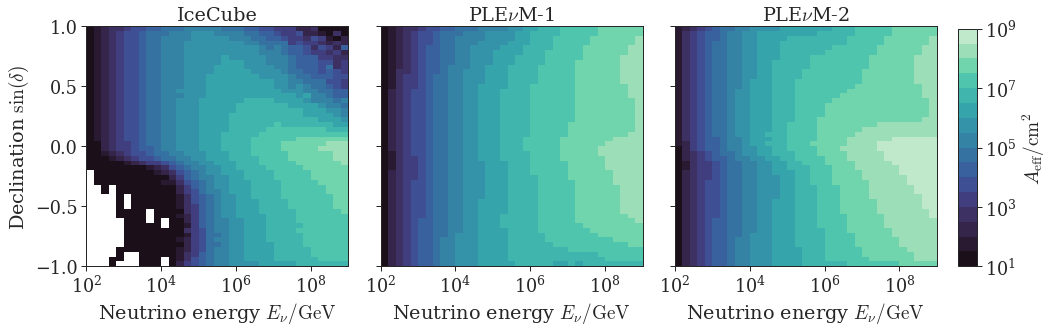

In [28]:
fig, axes=plt.subplots(ncols=3, figsize=(15,5), sharey=True)

ax = axes[0]
ax.set_title('IceCube')
p = ax.pcolormesh(
    ebins,
    sindec_bins, 
    aeff_i_full['IceCube'].T,
    norm=LogNorm(),
    vmin=10,
    vmax=1E9,
    cmap=cmap
)
ax.set_xscale("log")
ax.set_xlim(1E2, 1E9)
ax.set_ylabel(r'Declination $\sin(\delta)$')

ax = axes[1]
ax.set_title(r'PLE$\nu$M-1')
p = ax.pcolormesh(
    ebins,
    sindec_bins, 
    aeff_i_full['Plenum-1'].T,
    norm=LogNorm(),
    vmin=10,
    vmax=1E9,
    cmap=cmap
)
ax.set_xscale("log")
ax.set_xlim(1E2, 1E9)

ax = axes[2]
ax.set_title(r'PLE$\nu$M-2')
p = ax.pcolormesh(
    ebins,
    sindec_bins, 
    aeff_i_full['Plenum-2'].T,
    norm=LogNorm(),
    vmin=10,
    vmax=1E9,
    cmap=cmap
)
ax.set_xscale("log")
ax.set_xlim(1E2, 1E9)

for ax in axes:
    ax.set_xlabel(r'Neutrino energy $E_\nu/{\rm GeV}$')
fig.tight_layout()
cbax = fig.add_axes([0.9, 0.22, 0.017, 0.66]) 
cb = fig.colorbar(p, cax=cbax)
cb.set_label(r'$A_{\rm eff} / \rm cm^2$')
fig.subplots_adjust(right=0.88)
fig.savefig("../plots/aeff_comparison_IC_PLENUM-1-2.pdf")

# Smearing matrix

### energy and angular smearing

In [16]:
public_data_hist = np.genfromtxt(
    "../icecube_10year_ps/irfs/IC86_II_smearing.csv",
    skip_header=1
)
# #   0                    1                    2                  3                4                 5 
# #  log10(E_nu/GeV)_min  log10(E_nu/GeV)_max  Dec_nu_min[deg]  Dec_nu_max[deg]  log10(E/GeV)_min  log10(E/GeV)_max
# #   6                7            8               9                 10
# #  PSF_min[deg]  PSF_max[deg]  AngErr_min[deg]  AngErr_max[deg]  Fractional_Counts

In [17]:
log_sm_emin, log_sm_emax = public_data_hist[:,0], public_data_hist[:,1]
log_sm_emids = (log_sm_emin + log_sm_emax) / 2.

sm_dec_min, sm_dec_max = public_data_hist[:,2], public_data_hist[:,3]
sm_dec_mids = (sm_dec_min + sm_dec_max) / 2.

log_sm_ereco_min, log_sm_ereco_max = public_data_hist[:,4], public_data_hist[:,5]
log_sm_ereco_mids = (log_sm_ereco_min + log_sm_ereco_max) / 2.

log_psf_min, log_psf_max = np.log10(public_data_hist[:,6]), np.log10(public_data_hist[:,7])
log_psf_mids = (log_psf_min + log_psf_max) / 2.

log_sigma_min, log_sigma_max = np.log10(public_data_hist[:,8]), np.log10(public_data_hist[:,9])
log_sigma_mids = (log_sigma_min + log_sigma_max) / 2.

fractional_event_counts = public_data_hist[:,10]

dec_binning = np.unique(np.concatenate([sm_dec_min, sm_dec_max]))
log_psf_binning = np.linspace(-4.5, 2.5, 25)
ebinning = np.arange(0.5, 9, 0.5)
log_sigma_binning = np.linspace(-0.7, 1.2, 26)

## apply PSF smearing
there are three bins in declination

# WIP

In [19]:
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

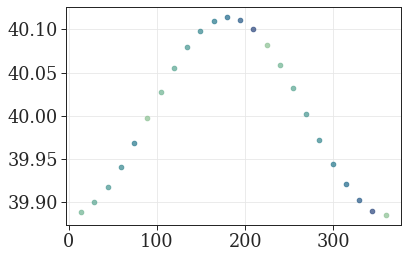

In [20]:
time = Time('2021-6-21 00:00:00', scale="utc")
plt.figure()
for i in range(24):
    loc = EarthLocation(
        lat=50,
        lon=(0 + i * 360/24) % 360
    )
    a = SkyCoord(0, 0, unit="radian", frame=AltAz(obstime=time, location=loc))
    plt.scatter(a.icrs.ra, a.icrs.dec, alpha=0.7)

# Plot some slices of this smearing matrix

### point spread function $\Psi = | \vec{\Omega}_{\rm true} - \vec{\Omega}_{\rm reco} |$

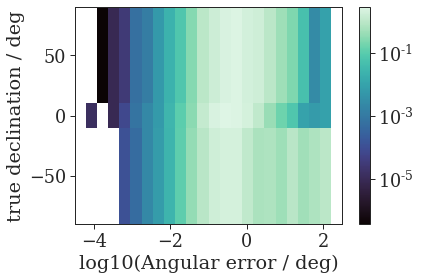

In [21]:
## visualization
# original binning
h, _, _, _ = plt.hist2d(
    log_psf_mids,
    sm_dec_mids,
    (log_psf_binning, dec_binning),
    weights = fractional_event_counts,
    norm=LogNorm()
)
plt.ylabel("true declination / deg")
plt.xlabel("log10(Angular error / deg)")
plt.colorbar()

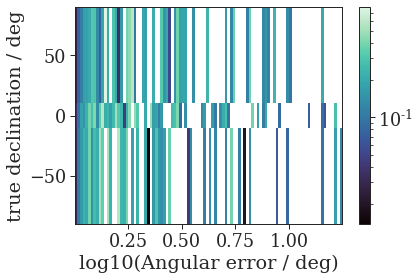

In [34]:
## visualization
# original binning
mask = log_psf_mids < 0.1
h, _, _, _ = plt.hist2d(
    np.power(10, log_psf_mids[mask]),
    sm_dec_mids[mask],
    bins=(100, dec_binning),
    weights = fractional_event_counts[mask],
    norm=LogNorm()
)
plt.ylabel("true declination / deg")
plt.xlabel("log10(Angular error / deg)")
plt.colorbar()

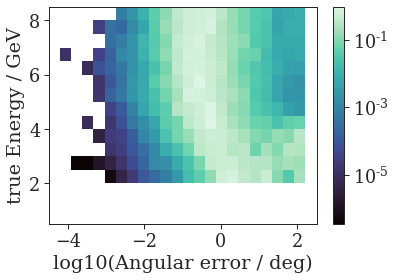

In [22]:
## visualization
# original binning
h, _, _, _ = plt.hist2d(
    log_psf_mids,
    log_sm_emids,
    (log_psf_binning, ebinning),
    weights = fractional_event_counts,
    norm=LogNorm()
)
plt.ylabel("true Energy / GeV")
plt.xlabel("log10(Angular error / deg)")
plt.colorbar()

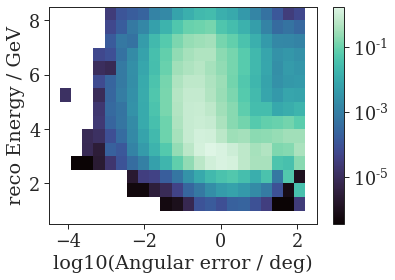

In [23]:
## visualization
# original binning
h, _, _, _ = plt.hist2d(
    log_psf_mids,
    log_sm_ereco_mids,
    (log_psf_binning, ebinning),
    weights = fractional_event_counts,
    norm=LogNorm()
)
plt.ylabel("reco Energy / GeV")
plt.xlabel("log10(Angular error / deg)")
plt.colorbar()

### angular reco error estimator (sigma)

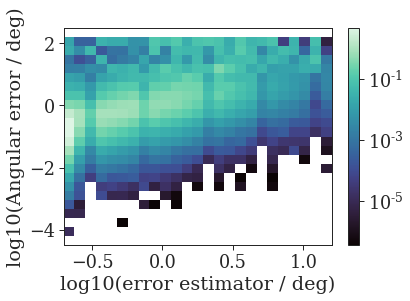

In [24]:
h, _, _, _ = plt.hist2d(
    log_sigma_mids,
    log_psf_mids,
    (log_sigma_binning, log_psf_binning),
    weights = fractional_event_counts,
    norm=LogNorm()
)
plt.xlabel("log10(error estimator / deg)")
plt.ylabel("log10(Angular error / deg)")
plt.colorbar()

### energy

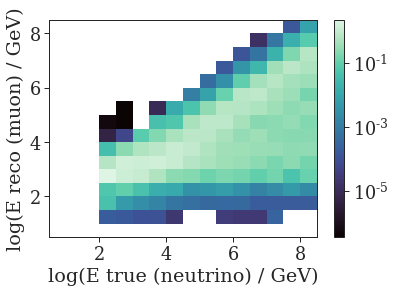

In [25]:
## visualization
# original binning
_ = plt.hist2d(
    log_sm_emids,
    log_sm_ereco_mids,
    ebinning,
    weights = fractional_event_counts,
    norm = LogNorm()
)
plt.ylabel("log(E reco (muon) / GeV)")
plt.xlabel("log(E true (neutrino) / GeV)")
plt.colorbar()

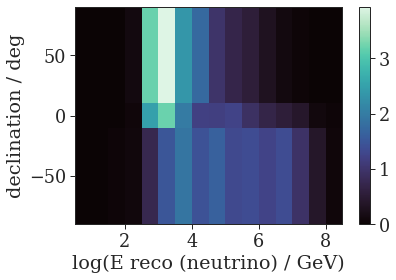

In [26]:
## visualization
# original binning
_ = plt.hist2d(
    log_sm_ereco_mids,
    sm_dec_mids,
    (ebinning, dec_binning),
    weights = fractional_event_counts,
)
plt.ylabel("declination / deg")
plt.xlabel("log(E reco (neutrino) / GeV)")
plt.colorbar()

# energy kde

In [27]:
from scipy.stats import gaussian_kde

In [28]:
eri = get_mids(np.arange(0.5, 9, 0.2))
log_emids = get_mids(np.log10(ebins))
ee, rr = np.meshgrid(log_emids, eri)

In [29]:
e_ereco_kdes = gaussian_kde(
    (log_sm_emids, log_sm_ereco_mids),
    weights=fractional_event_counts
)
# kvals has shape ereco x etrue
kvals = e_ereco_kdes([ee.flatten(),rr.flatten()]).reshape(len(eri), len(log_emids))

with open("../resources/energy_smearing_kde.pckl", "wb") as f:
    pickle.dump(kvals, f)

Text(0.5, 0, 'log(E true (neutrino) / GeV)')

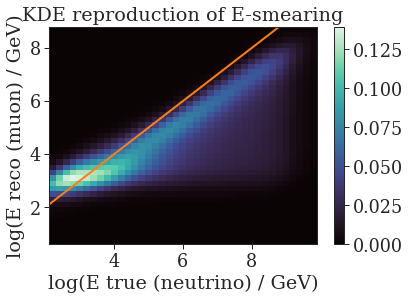

In [30]:
plt.pcolormesh(
    ee,
    rr,
    kvals
)
plt.colorbar()
plt.plot([1, 9], [1, 9], color="tab:orange")
plt.ylim(np.min(rr), np.max(rr))
plt.xlim(np.min(ee), np.max(ee))
plt.title("KDE reproduction of E-smearing")
plt.ylabel("log(E reco (muon) / GeV)")
plt.xlabel("log(E true (neutrino) / GeV)")

Text(0.5, 0, 'log(E true (neutrino) / GeV)')

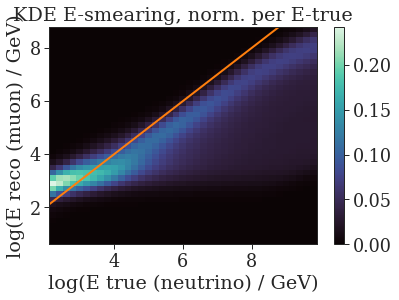

In [31]:
normed_kvals = kvals/np.sum(kvals, axis=0)
plt.pcolormesh(
    ee,
    rr,
    normed_kvals
)
plt.colorbar()
plt.plot([1, 9], [1, 9], color="tab:orange")
plt.ylim(np.min(rr), np.max(rr))
plt.xlim(np.min(ee), np.max(ee))
plt.title("KDE E-smearing, norm. per E-true")
plt.ylabel("log(E reco (muon) / GeV)")
plt.xlabel("log(E true (neutrino) / GeV)")

### show aeff in true energy and reco energy

Text(0, 0.5, '$\\sin(\\delta)$')

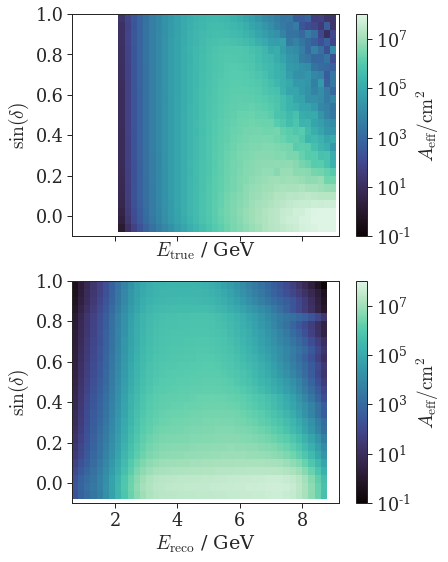

In [32]:
label = "10yr IceCube"

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6,9))
im = ax1.pcolormesh(
    log_emids,
    sindec_bins,
    aeff_2d["icecube"].T,
    norm=LogNorm(),
    vmin=0.1,
    vmax=1E8
)
plt.colorbar(im, ax=ax1, label=r"$A_{\rm eff} / \rm cm^2$")
ax1.set_ylim(-0.1, 1)
ax1.set_xlim(np.min(eri), 9.2)
ax1.set_xlabel(r"$E_{\rm true}$ / GeV")
ax1.set_ylabel(r"$\sin(\delta)$")
im = ax2.pcolormesh(
    eri,
    sindec_bins,
    np.dot(normed_kvals, aeff_2d["icecube"]).T,
    norm=LogNorm(),
    vmin=0.1,
    vmax=1E8
)
plt.colorbar(im, ax=ax2, label=r"$A_{\rm eff} / \rm cm^2$")
ax2.set_ylim(-0.1, 1)
ax2.set_xlim(np.min(eri), 9.2)
ax2.set_xlabel(r"$E_{\rm reco}$ / GeV")
ax2.set_ylabel(r"$\sin(\delta)$")